In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [34]:
from requirements import *
from utils.pl.plot_embedding import plot_embedding
from utils.pl.plot_custom import *
from scipy.cluster.hierarchy import linkage, dendrogram

## Import AnnDatas

In [190]:
# Read in KG146 tumor data for mapping
filepath = f'{data_dir}/h5ads/Untreated_Epithelial.h5ad'
ad_unt = sc.read_h5ad(filepath, backed=False)

## ED Figure 2a. Cell Types

/home/moormana/miniconda2/envs/crc-plasticity/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


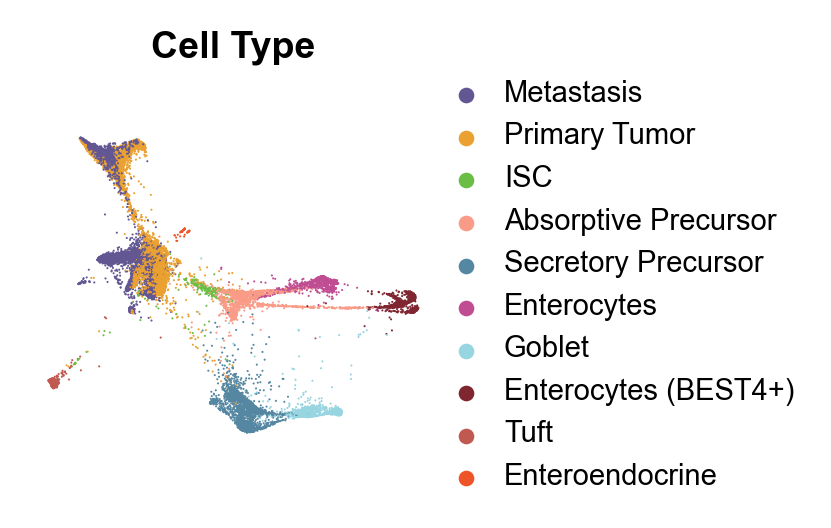

In [4]:
fig = plot_embedding(
    ad_unt,
    'Cell Type',
    basis='X_draw_graph_fa',
    palette=named_colors,
    dim=2,
    s=1,
    rasterized=True,
)
fig.savefig(f'{media_dir}/ed_figure_3a.svg')

## ED Figure 2c. ISC Signature

In [5]:
# Get ISC DEGs obtained with MAST
isc_diffex = pd.read_excel(
    f'{data_dir}/tables/Supplementary_Table_1.xlsx',
    skiprows=1,
    index_col=0,
    sheet_name='c',
)
isc_signature = isc_diffex[isc_diffex['ISC Signature'] == 1].index

In [6]:
ad_unt.X = ad_unt.layers['z-score']
name = 'ISC Signature Notebook'
sc.tl.score_genes(ad_unt, isc_signature, use_raw=False, score_name=name)

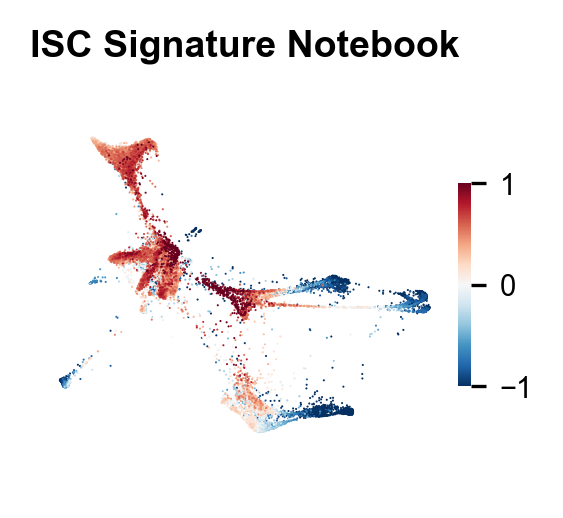

In [7]:
fig = plot_embedding(
    ad_unt,
    'ISC Signature Notebook',
    basis='X_draw_graph_fa',
    palette=named_colors,
    dim=2,
    s=1,
    vmin=-1,
    vmax=1,
    rasterized=True,
    cmap='RdBu_r',
)
fig.savefig(f'{media_dir}/ed_figure_3c.svg')

## ED Figure 3d. ISC signature and PC 1 by cell type

In [110]:
# Order for plot
cell_type_order = [
    'Enterocytes (BEST4+)',  
    'Goblet',
    'Enterocytes',
    'Secretory Precursor',
    'Absorptive Precursor',
    'ISC',
    'Metastasis',
    'Primary Tumor',
]

ad_unt.obs['Cell Type'] = pd.Categorical(
    ad_unt.obs['Cell Type'],
    ordered=True,
    categories=cell_type_order,
)
mask = ad_unt.obs['Cell Type'].isin(cell_type_order)

# Reverse for consistency in order
ad_unt.obs['PC 1'] = -ad_unt.obsm['X_pca'].T[0]

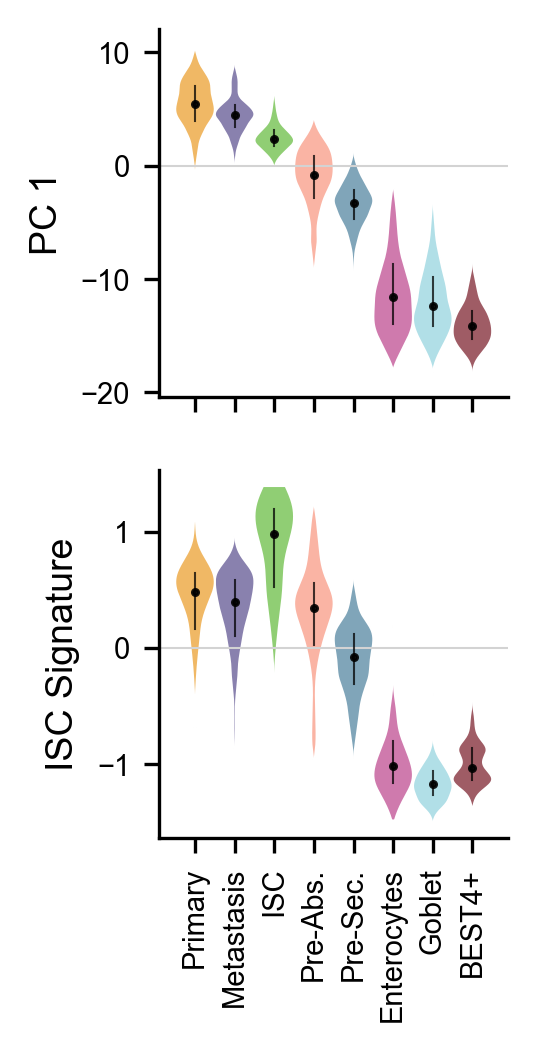

In [111]:
fig, axes = plt.subplots(2, 1, figsize=(1.5, 3.5), sharex=True)

for ax, col in zip(axes.flat, ['PC 1', 'ISC Signature']):
    plot_violin(ad_unt.obs[mask], 'Cell Type', col, named_colors, ax)
    ax.set_ylabel(col)
    ax.axhline(0, lw=0.5, color='lightgray', zorder=1)
    labels = [abbreviations[ct] for ct in cell_type_order]
    ax.set_xticklabels(labels, rotation=90)

fig.savefig(f'{media_dir}/ed_figure_3d.svg')

## ED Figure 3e. Heatmap of ISC Genes

In [297]:
# Summary data per cell type
isc_degs = ad_unt.var.index[ad_unt.var['ISC DEG']]
isc_degs_summary = pd.DataFrame(
    ad_unt[:, isc_degs].layers['z-score'],
    columns=isc_degs,
).groupby(ad_unt.obs["Cell Type"].values).mean().T
isc_degs_summary['Cluster'] = ad_unt.var.loc[isc_degs, 'ISC Cluster']
vlines = isc_degs_summary['Cluster'].value_counts(sort=False).cumsum()

In [298]:
# Order for plot
cell_type_order = [
    'Tuft',
    'Enteroendocrine',
    'Enterocytes (BEST4+)',  
    'Goblet',
    'Enterocytes',
    'Secretory Precursor',
    'Absorptive Precursor',
    'ISC',
    'Metastasis',
    'Primary Tumor',
]

In [299]:
# Reorder
row_order = []
for name, group in isc_degs_summary.groupby('Cluster', observed=True):
    lkg = linkage(group, method="single")
    leaves = dendrogram(lkg, no_plot=True)['leaves']
    row_order += group.index[leaves].to_list()
isc_degs_summary = isc_degs_summary.loc[row_order, cell_type_order]
isc_degs_summary.rename(abbreviations, axis=1, inplace=True)

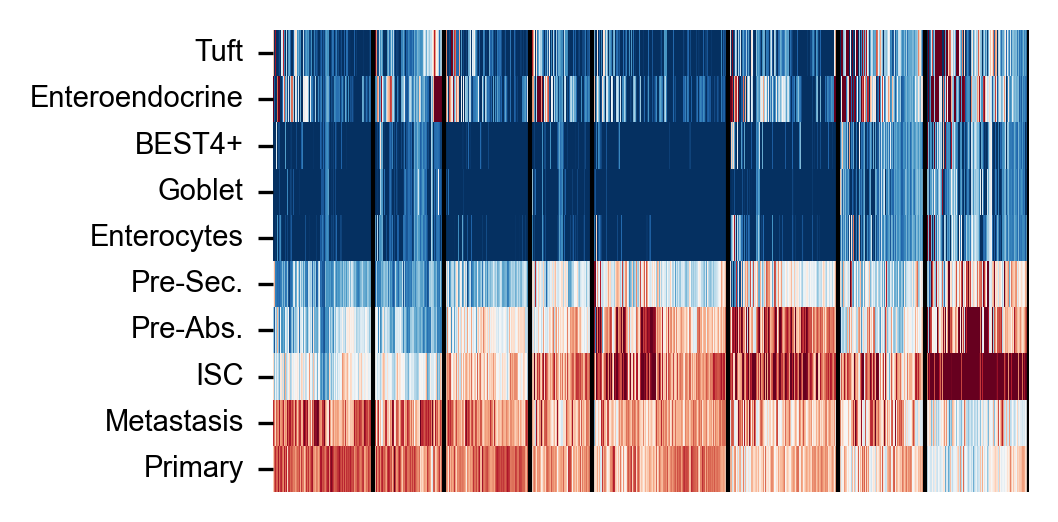

In [305]:
# Draw heatmap
fig, ax = plt.subplots(
    1,1, 
    figsize=(3.25, 2)
)
sns.heatmap(
    isc_degs_summary.T,
    vmin=-1, vmax=1,
    cmap="RdBu_r",
    ax=ax, cbar=False,
    yticklabels=True,
    xticklabels=False,
)
for v in vlines:
    ax.axvline(v, lw=1, color='k')